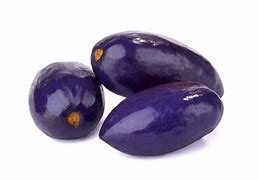
<center>
<h1><font size="+3">JCIA Hackathon 2025 : Classification Automatique des Prunes Africaines</font></h1>
</center>

---
<center>
<H1 style="color:black">

</H1>
</center>

---

<center>
<H1 style="color:black">
 1 . Objectif du Projet
</H1>
</center>

Ce projet a été réalisé dans le cadre du Hackathon JCIA 2025 sous le thème « Intelligence Artificielle et Développement Économique : Innover pour transformer ». L’objectif est de **concevoir une solution de vision par ordinateur permettant de classifier automatiquement les prunes africaines selon leur qualité**. Le modèle doit être à la fois performant, interprétable et déployable facilement via une interface utilisateur intuitive.

----
### Catégories à prédire :

   - `unaffected`: prune de bonne qualité
   - `unripe`    : non mûre
   - `spotted`   : tacheté
   - `cracked`   : fissuré
   - `bruised`   : meurtri
   - `rotten`    : pourrie

Le système repose sur des **modèles de vision par ordinateur (CNN)** combinés à des techniques de **transfer learning** pour identifier automatiquement la catégorie de chaque prune à partir d’images.

-----
### Technologies utilisées

- `PyTorch`, `torchvision`, `timm`
- `EfficientNet`, `GoogLeNet`, `ResNet`
- `scikit-learn` pour les métriques
- `Matplotlib` / `Seaborn` pour les visualisations
- Dataset : [African Plums Dataset (Kaggle)](https://www.kaggle.com/datasets/killa92/african-plums-quality-and-defect-assessment-data)

----

  ### Étapes du projet

| Étape                            | Description                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
|  **Exploration des donnees**     | Visualisation des classes et déséquilibres                                  |
| **Prétraitement des donnees**    | Redimensionnement en `224x224`, normalisation `mean/std`                    |
| **Augmentation des données**     | Uniquement sur les classes sous-représentées ( `cracked`, `bruised`)     |
| **Modélisation**                 | Entraînement de plusieurs CNN pré-entraînés pour comparer les performances  |
| **Évaluation & visualisation**   | F1-macro, Précision, Rappel, visualisation d’images   |
| **Comparaison finale**           | Choix du modèle le plus performant  


## 2. Exploration des données

---

  ### 2.1 Recuperer les données

In [1]:
# 1. Monter Google Drive
from google.colab import drive  # On importe la librairie pour accéder à Google Drive
import os  # Importation de os pour gérer les chemins de fichiers

# On monte le Drive à l’emplacement /content/drive dans l’environnement Colab
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


ici on commence par connecter le Google Drive au notebook Colab. Comme ça on a  accé aux images et aux modèles qu'on sauvegarder dans le dossier "MyDrive".

In [2]:
# 2. Dézipper le dataset depuis le Drive
import zipfile  # On importe zipfile pour pouvoir extraire les fichiers d’un .zip

zip_path = '/content/drive/MyDrive/plums.zip'  # Chemin du fichier zip sur notre Google Drive

extract_path = '/content/african_plums_dataset'  # Emplacement où on va extraire le contenu du zip

# Ouverture et extraction des fichiers du zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Tous les fichiers sont extraits dans le dossier cible




On précise d'abord où se trouve le fichier (zip_path) puis l’endroit où on veut tout extraire (`extract_path`).
Ensuite avec la fonction `extractall`, tous les fichiers sont automatiquement décompressés.
C’est comme ça qu’on prépare nos données avant de pouvoir les explorer ou les charger.

In [3]:
os.listdir('/content/african_plums_dataset/african_plums_dataset/african_plums')


['unripe', 'bruised', 'spotted', 'rotten', 'unaffected', 'cracked']

On utilise `os.listdir()` pour voir ce qu’il y a dans le dossier des prunes qu’on vient de dézipper.
ça nous retourne les 6 catégories : bruised, cracked, rotten, spotted, unaffected et unripe.
C’est utile pour vérifier que le dataset a bien été extrait et que les classes sont bien organisées par dossier

In [4]:
# Le chemin final vers les dossiers de classes :
DATA_DIR = '/content/african_plums_dataset/african_plums_dataset/african_plums'

### 2.2 Distribution des Images par Classe

In [5]:

from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

image_paths = glob(f"{DATA_DIR}/*/*.png")
classes = [os.path.basename(os.path.dirname(p)) for p in image_paths]
unique_classes = sorted(set(classes))
class_counts = {cls: classes.count(cls) for cls in unique_classes}

Ici on commence l’exploration de notre dataset.
On liste toutes les images du dossier, puis on extrait le nom de la classe à partir du dossier parent.
Ensuite on compte combien d’images il y a pour chaque classe.
Ça va nous aider à visualiser si le dataset est équilibré ou pas

<ipython-input-9-7743dc6f66cb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


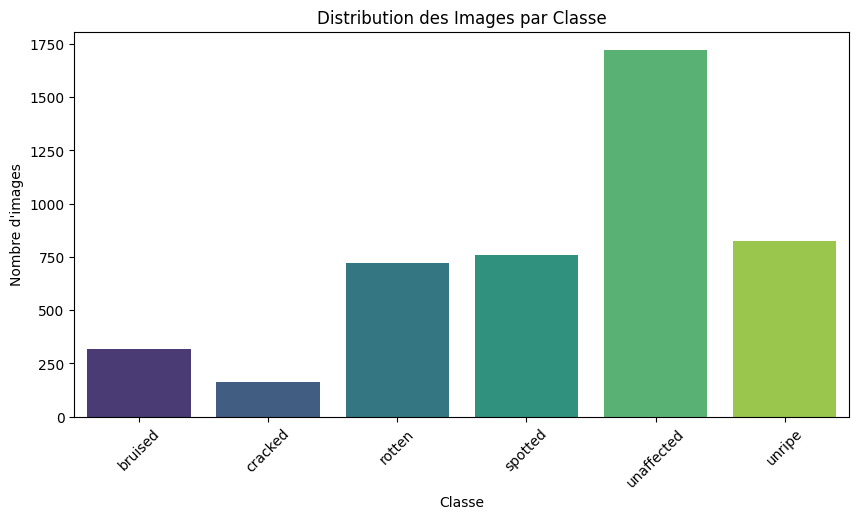

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Distribution des Images par Classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.show()

Chaque classe est stockée dans un répertoire distinct. ce graphique a été généré pour analyser la distribution des classes.

Grace a ce graphique , nous  constatons un **déséquilibre important entre les classes** :

- Certaines classes comme `unaffected` et `unripe` compte plus  de 750 images
- Tandis que des classes comme `cracked` et `bruised` ont  moins de 300 images

### Résultat :

le dataset est `déséquilibré`, certaines classes comme
`cracked` et `bruised` sont sous-représentées.

### 2.3 visualisation d'images par classe

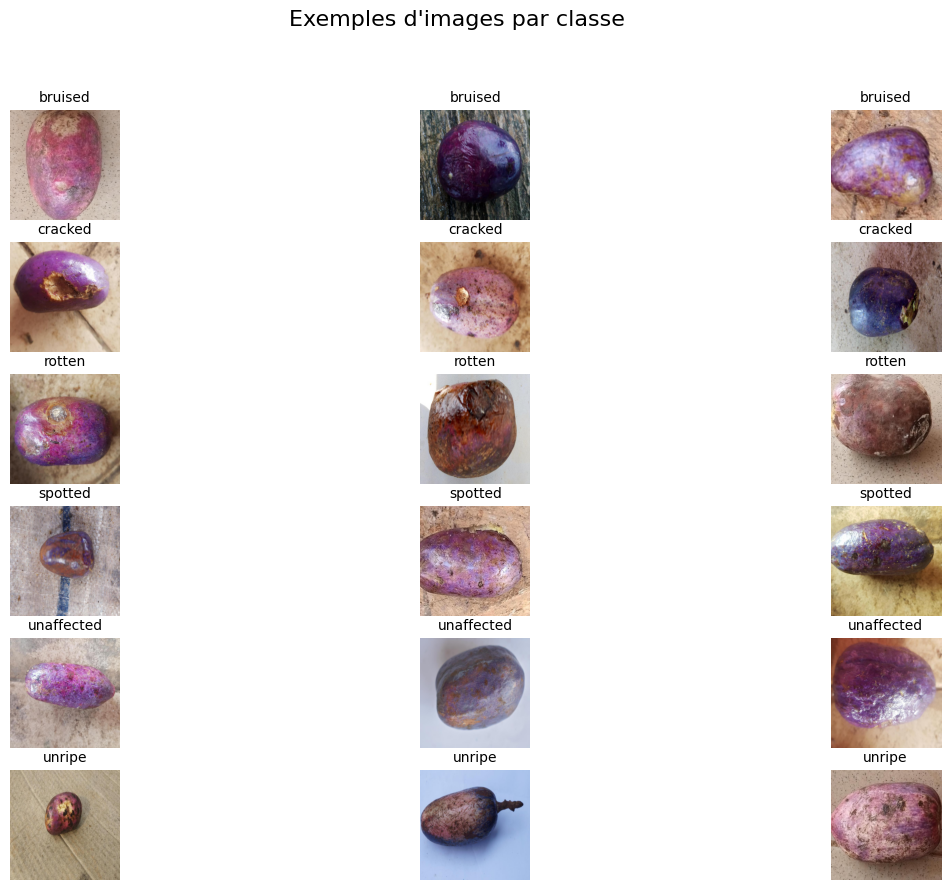

In [ ]:
# 4. Affichage de quelques images par classe
n_images = 3
plt.figure(figsize=(15, 10))
for idx, cls_name in enumerate(unique_classes):
    cls_imgs = [p for p in image_paths if cls_name in p][:n_images]
    for i, img_path in enumerate(cls_imgs):
        plt.subplot(len(unique_classes), n_images, idx * n_images + i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls_name, fontsize=10)
plt.suptitle("Exemples d'images par classe", fontsize=16)
plt.show()

cette affichage visuel d'exemples d'images par classe a permis de confirmer l’intégrité des données.

## 3. Pretraitement des donnees

- Redimensionnement des images à 224x224 (taille standard des modèles CNN pré-entraînés)

- Normalisation des canaux RGB avec la moyenne et écart-type calculés sur les 1000 premières images

- Augmentation des donnnees sur des classes sous representées

###  3.1 Statistiques globales (moyenne, écart-type)

les statistiques globales des images (moyennes et écart-types) ont été calculées sur un échantillon de 1000 images pour normaliser les entrées du réseau.

In [6]:
# Calcul des statistiques (mean, std)
import torch
from torchvision import transforms

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
means, stds = [], []

for path in image_paths[:1000]:    # Échantillon pour rapidité
    img = Image.open(path).convert('RGB')
    t_img = transform(img)
    means.append(t_img.mean(dim=(1,2)))
    stds.append(t_img.std(dim=(1,2)))

mean = torch.mean(torch.stack(means), dim=0)
std = torch.mean(torch.stack(stds), dim=0)
print(f"Moyenne : {mean}")
print(f"Écart-type : {std}")

Moyenne : tensor([0.6185, 0.5113, 0.5015])
Écart-type : tensor([0.1693, 0.1890, 0.1853])


Pour normaliser nos images, nous avons calculé la moyenne et l’écart-type par canal (R, G, B) à partir d’un échantillon de 1000 images. Ce sous-échantillonnage permet d’obtenir des statistiques fiables tout en évitant des calculs coûteux. Ces valeurs sont ensuite utilisées pour normaliser les données d’entrée, ce qui accélère et stabilise l’apprentissage du modèle.

----

### 3.2  Augmentation des Données

Deux Etapes de transformation ont été définis.

-  Le premier applique une mise à l’échelle, un `flip horizontal` et une normalisation standard.

-  Le second, destiné aux classes minoritaires (cracked, bruised), applique des augmentations supplémentaires (rotation, jitter, contraste , saturation) afin d'équilibrer les classes et d'améliorer la généralisation.


   ##### Pourquoi avons nous augmentées les données?


Ce choix est justifié par **l'observation du déséquilibre de classes dans les données**. L’augmentation ciblée permet d’éviter le sur-apprentissage des classes dominantes tout en enrichissant la diversité visuelle du dataset.

Ce déséquilibre peut `biaiser l’entraînement du modèle`, car il verra davantage les classes majoritaires, ce qui peut conduir a ca:

- Un modèle qui prédit majoritairement les classes les plus fréquentes
- Un faible rappel pour les classes rares

**Objectif** : réduire le déséquilibre de classes, améliorer la généralisation du modèle

In [7]:
#  DATASET PERSONNALISÉ + AUGMENTATION CIBLÉE

#1.  transformations standard

from torch.utils.data import Dataset, DataLoader, random_split

standard_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Uniformise la taille pour tous les modèles pré-entraînés
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),# Convertit les images PIL en tenseurs PyTorch
    transforms.Normalize(mean=mean, std=std)# Normalisation avec les valeurs calculées
])

augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),# Rotation aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Variations de couleurs
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),# Petit déplacement
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

#2. Création d’un dataset personnalisé avec augmentation ciblée

class CustomPlumDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform_normal, transform_augmented, minority_classes):
        self.image_paths = glob(f"{root_dir}/*/*.png")
        self.class_to_idx = class_to_idx
        self.transform_normal = transform_normal
        self.transform_augmented = transform_augmented
        self.minority_classes = minority_classes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx[label_name]
        image = Image.open(img_path).convert("RGB")

 # Si l’image appartient à une classe minoritaire, on applique des augmentations
        if label_name in self.minority_classes:
            image = self.transform_augmented(image)
        else:
            image = self.transform_normal(image)

        return image, label

#3. Préparation des noms de classes, mapping et dataset
class_names = sorted(os.listdir(DATA_DIR)) # Liste triée des noms de classes
class_to_idx = {cls: i for i, cls in enumerate(class_names)}
minority_classes = ['cracked', 'bruised'] # Classes à augmenter

dataset = CustomPlumDataset(DATA_DIR, class_to_idx, standard_transform, augmented_transform, minority_classes)


Ce code nous sert à construire un dataset  sur-mesure.
Les classes sous-représentées comme "cracked" et "bruised" sont boostées avec des augmentations visuelles.
Comme ça notre modèle voit plus de variations et apprend mieux sur les classes rares.
Ça aide à équilibrer sans recopier  les images.

In [8]:
#  DataLoaders:Préparation des ensembles d'entraînement, validation et test

#Division du dataset en 80% train, 10% validation, 10% test

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

#Découpage du dataset selon les tailles définies
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

#Chargement des données sous forme de DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)# Le shuffle évite les biais d’ordre
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)


Ici on divise notre dataset en trois parties :
- 80% pour entraîner le modèle

- 10% pour valider à chaque époque

- 10% pour tester à la fin.

Les DataLoaders permettent de charger les données par lot (`batch de 32 ici`), ce qui rend l’entraînement plus rapide et stable.
On mélange le train avec shuffle=True pour éviter que le modèle apprenne un ordre en particulier .

# 4 . Entrainement du modèle

Pour ce projet Nous allons implementer  differents modeles pré-entraînés CNN, en resortir avec un modele satisfaisant pour classifier nos prunes correctement .

### Pourquoi utiliser des modèles pré-entraînés (Transfer Learning) ?

Les modèles comme EfficientNet, GoogLeNet, ResNet et ConvNeXt ont été :
- Entraînés sur de larges bases d’images (ex: ImageNet avec 1.2M images, 1000 classes)
- Prouvés comme étant généraux et puissants pour l’extraction de caractéristiques visuelles

Avantages :

- Gain de temps (plus rapide que d’entraîner à partir de zéro)

- Meilleures performances avec peu de données

- Évite le surapprentissage

### 4.1 Fonction pour entraîner des modèles pré-entraînés CNN

In [9]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

#Cette fonction utilise `timm` pour charger un modèle CNN pré-entraîné (EfficientNet, ResNet)
# Elle adapte la dernière couche (`classifier` ou `fc`) pour correspondre au nombre de classes (6 pour les prunes)

def build_model(model_name, num_classes=6):
    model = timm.create_model(model_name, pretrained=False)

    # On remplace le classifieur final selon la structure du modèle
    if hasattr(model, 'classifier'):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        model.head = nn.Linear(model.head.in_features, num_classes)

    return model

#Fonction pour entraîner le modèle

def train_model(model_name, train_loader, val_loader, device, epochs=10, lr=3e-4, save_path='best_model.pth'):
    model = build_model(model_name).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_f1 = 0

    train_f1s, val_f1s = [], []  # Pour stocker les F1-scores à chaque époque

    for epoch in range(epochs):
        model.train()
        train_loss, y_true, y_pred = 0, [], []
          #Entraînement sur les batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            y_true += labels.cpu().tolist()
            y_pred += outputs.argmax(1).cpu().tolist()

        #F1-score entraînement
        train_f1 = f1_score(y_true, y_pred, average='macro')
        train_f1s.append(train_f1)
        print(f"\nEpoch {epoch+1} - Train F1: {train_f1:.4f} | Loss: {train_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss, y_true, y_pred = 0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                y_true += labels.cpu().tolist()
                y_pred += outputs.argmax(1).cpu().tolist()

        val_f1 = f1_score(y_true, y_pred, average='macro')
        val_f1s.append(val_f1)
        print(f"Validation F1: {val_f1:.4f} | Loss: {val_loss/len(val_loader):.4f}")

        #Sauvegarde du meilleur modèle
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print("✅ Meilleur modèle sauvegardé !")

    return model, train_f1s, val_f1s


Ici on  definit nos fonction d'entraînenement des  differents modèles CNN.
On a fait une `fonction build_model` pour créer des modèles  EfficientNet, ResNet .avec une dernière couche adaptée aux 6 classes de prunes.

Ensuite `train_model` fait tout le boulot d’entraînement, de validation et de sauvegarde du meilleur modèle.


On a choisi le `F1-score macro` comme critère principal car notre dataset est déséquilibré. car La simple `accuracy` peut être trompeuse (par exemple : un modèle peut ignorer une classe et avoir 80% d’accuracy). lui il  `prend en compte précision + rappel`, en donnant le même poids à chaque classe.
Idéal pour notre tâche où les classes comme cracked sont sous-représentées.

Le modèle est sauvegardé automatiquement dès qu’il fait mieux sur la validation.

------

## 4.2  Entraînement des modeles

Les modèles sont  entraînés pendant 10 époques avec :

- Optimiseur : `l’optimiseur Adam `(learning rate 3e-4)

- Perte : `CrossEntropyLoss`

- Métrique principale : `Le F1-score (macro)` est utilisé pour le suivi car il accorde une importance équitable à chaque classe, contrairement à l’accuracy qui peut masquer les erreurs sur les classes rares.

- Évaluation à chaque époque sur le jeu de validation

- Sauvegarde du meilleur modèle basé sur F1-score de validation

À chaque amélioration du score de validation, les poids du modèle sont sauvegardés pour éviter le surapprentissage.


## 1er modèle: Efficientnet_BO

In [ ]:
# Entraînement avec EfficientNet
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_efficientnet, train_f1s_efficientnet, val_f1s_efficientnet = train_model(
    model_name='efficientnet_b0',
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=3e-4,
    save_path='efficientnet_b0_best.pth'
)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Epoch 1 - Train F1: 0.6072 | Loss: 0.8156
Validation F1: 0.6734 | Loss: 0.5047
✅ Meilleur modèle sauvegardé !

Epoch 2 - Train F1: 0.7791 | Loss: 0.4581
Validation F1: 0.7565 | Loss: 0.5303
✅ Meilleur modèle sauvegardé !

Epoch 3 - Train F1: 0.8297 | Loss: 0.3716
Validation F1: 0.7148 | Loss: 0.5581

Epoch 4 - Train F1: 0.8630 | Loss: 0.2990
Validation F1: 0.7236 | Loss: 0.5780

Epoch 5 - Train F1: 0.8834 | Loss: 0.2361
Validation F1: 0.7685 | Loss: 0.6103
✅ Meilleur modèle sauvegardé !

Epoch 6 - Train F1: 0.8839 | Loss: 0.2187
Validation F1: 0.7888 | Loss: 0.5956
✅ Meilleur modèle sauvegardé !

Epoch 7 - Train F1: 0.9058 | Loss: 0.2155
Validation F1: 0.8112 | Loss: 0.6429
✅ Meilleur modèle sauvegardé !

Epoch 8 - Train F1: 0.9137 | Loss: 0.1772
Validation F1: 0.7812 | Loss: 0.8222

Epoch 9 - Train F1: 0.9196 | Loss: 0.1527
Validation F1: 0.7900 | Loss: 0.8627

Epoch 10 - Train F1: 0.9126 | Loss: 0.1515
Validation F1: 0.7824 | Loss: 0.9165


-----


## 2eme modèle: inception (googlenet)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_inception, train_f1s_inception, val_f1s_inception = train_model(
    model_name='inception_v3',
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=3e-4,
    save_path='inception_best.pth'
)


model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]


Epoch 1 - Train F1: 0.5999 | Loss: 0.8165
Validation F1: 0.6935 | Loss: 0.6957
✅ Meilleur modèle sauvegardé !

Epoch 2 - Train F1: 0.7147 | Loss: 0.5600
Validation F1: 0.7506 | Loss: 0.5616
✅ Meilleur modèle sauvegardé !

Epoch 3 - Train F1: 0.7778 | Loss: 0.4866
Validation F1: 0.7438 | Loss: 0.5756

Epoch 4 - Train F1: 0.8169 | Loss: 0.3898
Validation F1: 0.7507 | Loss: 0.6371
✅ Meilleur modèle sauvegardé !

Epoch 5 - Train F1: 0.8348 | Loss: 0.3681
Validation F1: 0.7374 | Loss: 0.6452

Epoch 6 - Train F1: 0.8278 | Loss: 0.3392
Validation F1: 0.7575 | Loss: 0.6739
✅ Meilleur modèle sauvegardé !

Epoch 7 - Train F1: 0.8503 | Loss: 0.3109
Validation F1: 0.7540 | Loss: 0.6519

Epoch 8 - Train F1: 0.8576 | Loss: 0.2846
Validation F1: 0.7218 | Loss: 0.8606

Epoch 9 - Train F1: 0.8817 | Loss: 0.2599
Validation F1: 0.6731 | Loss: 0.7526

Epoch 10 - Train F1: 0.8772 | Loss: 0.2450
Validation F1: 0.7191 | Loss: 0.7892


------

## 3eme modèle: ResNeXt50_32x4d

In [ ]:
# 🚀 Entraînement avec ResNeXt50_32x4d
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnext, train_f1s_resnext, val_f1s_resnext = train_model(
    model_name='resnext50_32x4d',
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=3e-4,
    save_path='resnext50_best.pth'
)



model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]


Epoch 1 - Train F1: 0.4162 | Loss: 1.0936
Validation F1: 0.5601 | Loss: 0.7566
✅ Meilleur modèle sauvegardé !

Epoch 2 - Train F1: 0.6388 | Loss: 0.6065
Validation F1: 0.6666 | Loss: 0.5274
✅ Meilleur modèle sauvegardé !

Epoch 3 - Train F1: 0.7363 | Loss: 0.4619
Validation F1: 0.7861 | Loss: 0.4745
✅ Meilleur modèle sauvegardé !

Epoch 4 - Train F1: 0.8044 | Loss: 0.3770
Validation F1: 0.7558 | Loss: 0.5146

Epoch 5 - Train F1: 0.8394 | Loss: 0.3348
Validation F1: 0.7804 | Loss: 0.5172

Epoch 6 - Train F1: 0.8606 | Loss: 0.2855
Validation F1: 0.7637 | Loss: 0.5478

Epoch 7 - Train F1: 0.8827 | Loss: 0.2612
Validation F1: 0.7428 | Loss: 0.6305

Epoch 8 - Train F1: 0.8982 | Loss: 0.2247
Validation F1: 0.7549 | Loss: 0.6311

Epoch 9 - Train F1: 0.9025 | Loss: 0.1975
Validation F1: 0.7679 | Loss: 0.6326

Epoch 10 - Train F1: 0.9204 | Loss: 0.1795
Validation F1: 0.7422 | Loss: 0.7421


----

# 5.Évaluation et Comparaison des Modèles

### 5.1 fonction pour l'evaluation

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch

def evaluate_model(model, model_path, test_loader, device, class_names):
    """
    Charge un modèle sauvegardé, prédit sur les données de test,
    puis affiche la précision globale et retourne les prédictions.
    """
    # Chargement du modèle sauvegardé
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            y_true += labels.cpu().tolist()
            y_pred += predictions.cpu().tolist()

    # Affichage des métriques (facultatif)
    print("📊 Rapport de classification :")
    print(classification_report(y_true, y_pred, target_names=class_names))

    #  Calcul de l'accuracy globale
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n✅ Précision globale : {accuracy:.4f} ({accuracy * 100:.2f}%)")

    return y_true, y_pred, accuracy


### 5.2 Implementation de l'evaluation et comparaison


🔍 Évaluation de inception_best → modèle TIMM : inception_v3
📊 Rapport de classification :
              precision    recall  f1-score   support

     bruised       0.86      0.66      0.75        29
     cracked       0.55      0.80      0.65        15
      rotten       0.90      0.93      0.92        59
     spotted       0.66      0.82      0.73        74
  unaffected       0.94      0.85      0.90       190
      unripe       0.93      0.89      0.91        85

    accuracy                           0.85       452
   macro avg       0.81      0.83      0.81       452
weighted avg       0.87      0.85      0.86       452


✅ Précision globale : 0.8518 (85.18%)

🔍 Évaluation de efficientnetb0_best → modèle TIMM : efficientnet_b0
📊 Rapport de classification :
              precision    recall  f1-score   support

     bruised       1.00      0.83      0.91        29
     cracked       0.71      1.00      0.83        15
      rotten       0.95      0.92      0.93        59
     spotte

Modèle  Accuracy (%)  F1-score  Recall  Précision
0     inception_v3         85.18    0.8077  0.8264     0.8059
1  efficientnet_b0         92.04    0.8974  0.9100     0.8956
2  resnext50_32x4d         81.42    0.7511  0.7376     0.7764

<ipython-input-12-ace50055dd89>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[df["Accuracy (%)"].notna()], x="Modèle", y="Accuracy (%)", palette="magma")


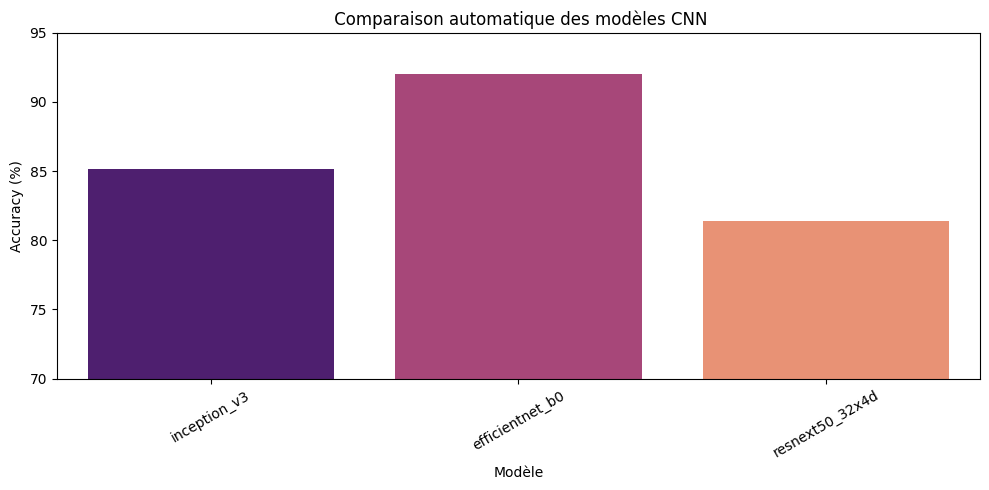

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#  Dossier contenant tes modèles sauvegardés
model_dir = "/content/drive/MyDrive/models"
class_names = ['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']

# Correspondance fichiers -> noms reconnus par timm
model_name_map = {
    "resnext50_32x4d": "resnext50_32x4d",
    "inception_best": "inception_v3",
    "efficientnetb0_best": "efficientnet_b0",
}

# Tous les fichiers .pth
model_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]

results = []

for file in model_files:
    file_key = file.replace(".pth", "")
    model_name = model_name_map.get(file_key, None)
    model_path = os.path.join(model_dir, file)

    print(f"\n🔍 Évaluation de {file_key} → modèle TIMM : {model_name}")

    if model_name is None:
        print(f"❌ Modèle non reconnu : {file_key}")
        results.append({"Modèle": file_key, "Erreur": "Modèle inconnu"})
        continue

    try:
        model = build_model(model_name, num_classes=len(class_names))
        y_true, y_pred, acc = evaluate_model(
            model=model,
            model_path=model_path,
            test_loader=test_loader,
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
            class_names=class_names
        )

        #  Calcul des métriques
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        accuracy = accuracy_score(y_true, y_pred)

        results.append({
            "Modèle": model_name,
            "Accuracy (%)": round(accuracy * 100, 2),
            "F1-score": round(f1, 4),
            "Recall": round(recall, 4),
            "Précision": round(precision, 4)
        })

    except Exception as e:
        print(f"❌ Erreur avec {model_name} : {e}")
        results.append({"Modèle": model_name, "Erreur": str(e)})

#  Résumé sous forme de tableau
df = pd.DataFrame(results)
display(df)

#  Affichage du graphique uniquement Accuracy
if "Accuracy (%)" in df.columns:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df[df["Accuracy (%)"].notna()], x="Modèle", y="Accuracy (%)", palette="magma")
    plt.title(" Comparaison automatique des modèles CNN")
    plt.ylim(70, 95)
    plt.xlabel("Modèle")
    plt.ylabel("Accuracy (%)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


D’après ce graphique et se tableau recapitulatif, `EfficientNet B0` serait donc le meilleur choix pour notre application, en termes de **précision globale, f1 score, de rappel**.

# 6.Visualisation

### 6.1 Fonction pour la visualisation



Cette fonction permet d'Afficher visuellement comment le modèle classifie les prunes testées, avec des couleurs pour signaler s’il s’est trompé (rouge) ou s’il a bien prédit (vert).

In [19]:
import random
import matplotlib.pyplot as plt

# Conversion en NumPy arrays
import numpy as np
mean = np.array(mean)
std = np.array(std)

def show_predictions(model, model_path, test_loader, class_names, device, num_images=14):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    images_shown = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in test_loader:
            if images_shown >= num_images:
                break
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    break

                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * std + mean).clip(0, 1)  # dénormalisation

                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                correct = true_label == pred_label

                plt.subplot(num_images // 4 + 1, 4, images_shown + 1)
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"GT: {true_label}\nPRED: {pred_label}",
                          color='green' if correct else 'red')
                images_shown += 1

    plt.tight_layout()
    plt.suptitle("Prédictions du modèle sur les images test", fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()

### 6.2 Affichage

#### 6.2.1 efficientnet_b0

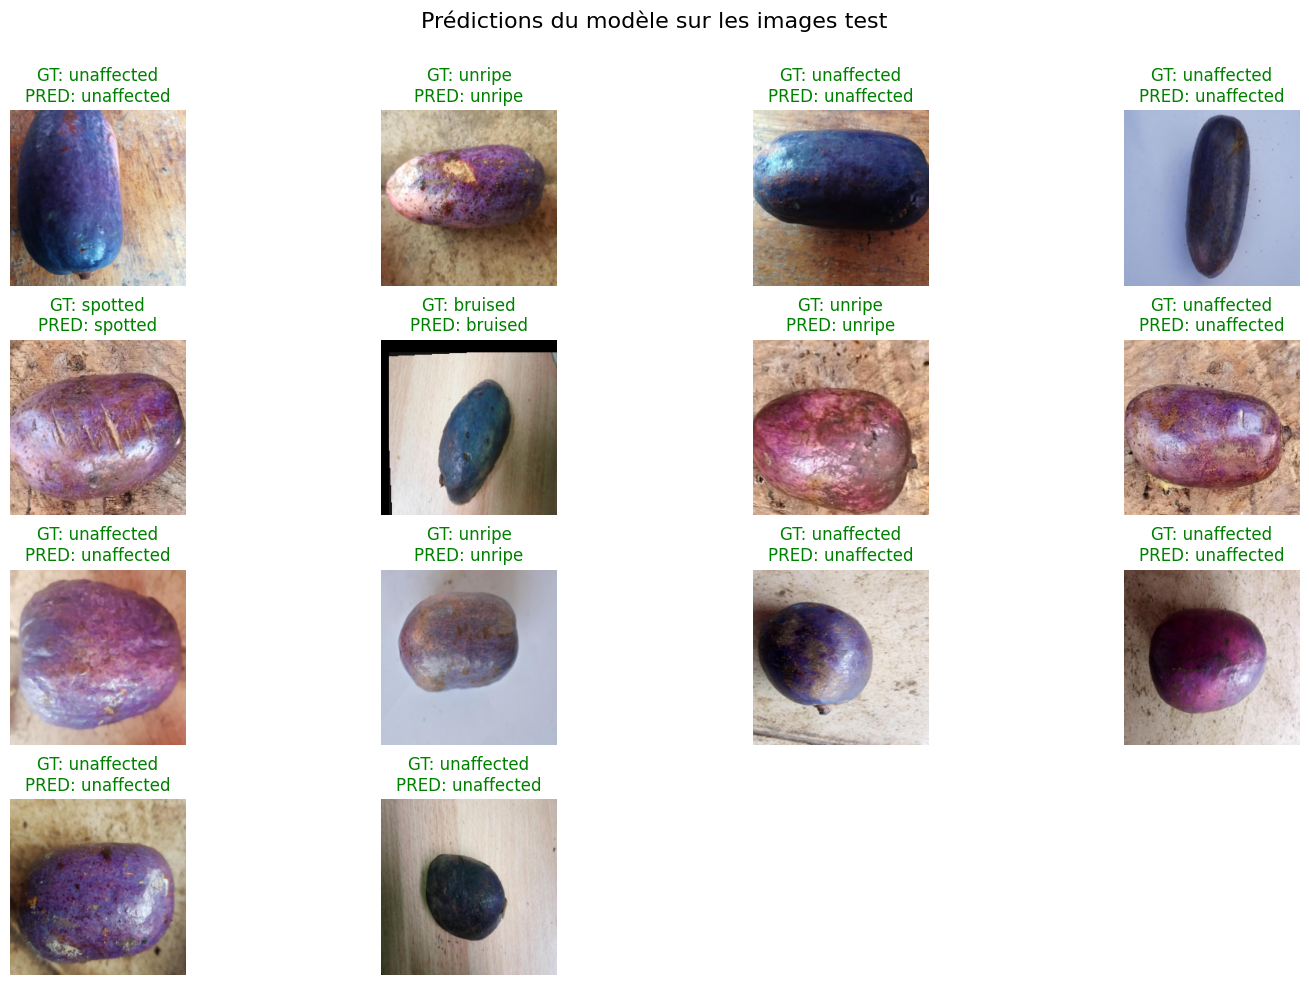

In [21]:
# Recréer le modèle avec la bonne architecture
model = build_model('efficientnet_b0', num_classes=len(class_names))

# Affichage
show_predictions(
    model=model,
    model_path='/content/drive/MyDrive/models/efficientnetb0_best.pth',
    test_loader=test_loader,
    class_names=class_names,
    device=device,
    num_images=14
)

 #### 6.2.2 inception_v3

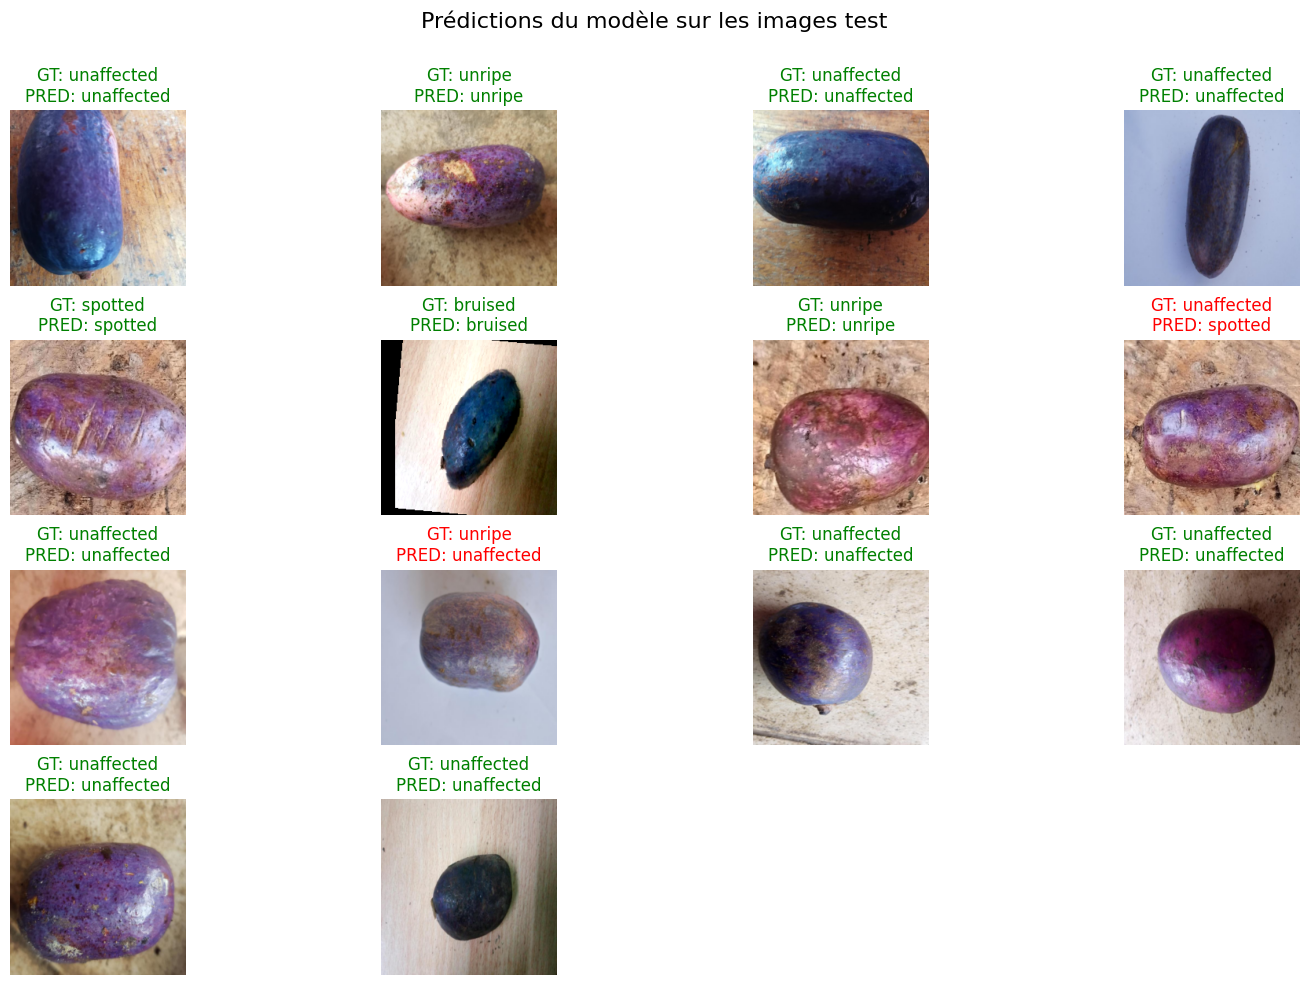

In [22]:
# Recréer le modèle avec la bonne architecture
model = build_model('inception_v3', num_classes=len(class_names))

# Affichage
show_predictions(
    model=model,
    model_path='/content/drive/MyDrive/models/inception_best.pth',
    test_loader=test_loader,
    class_names=class_names,
    device=device,
    num_images=14
)

6.2.3. resnext50_32x4d

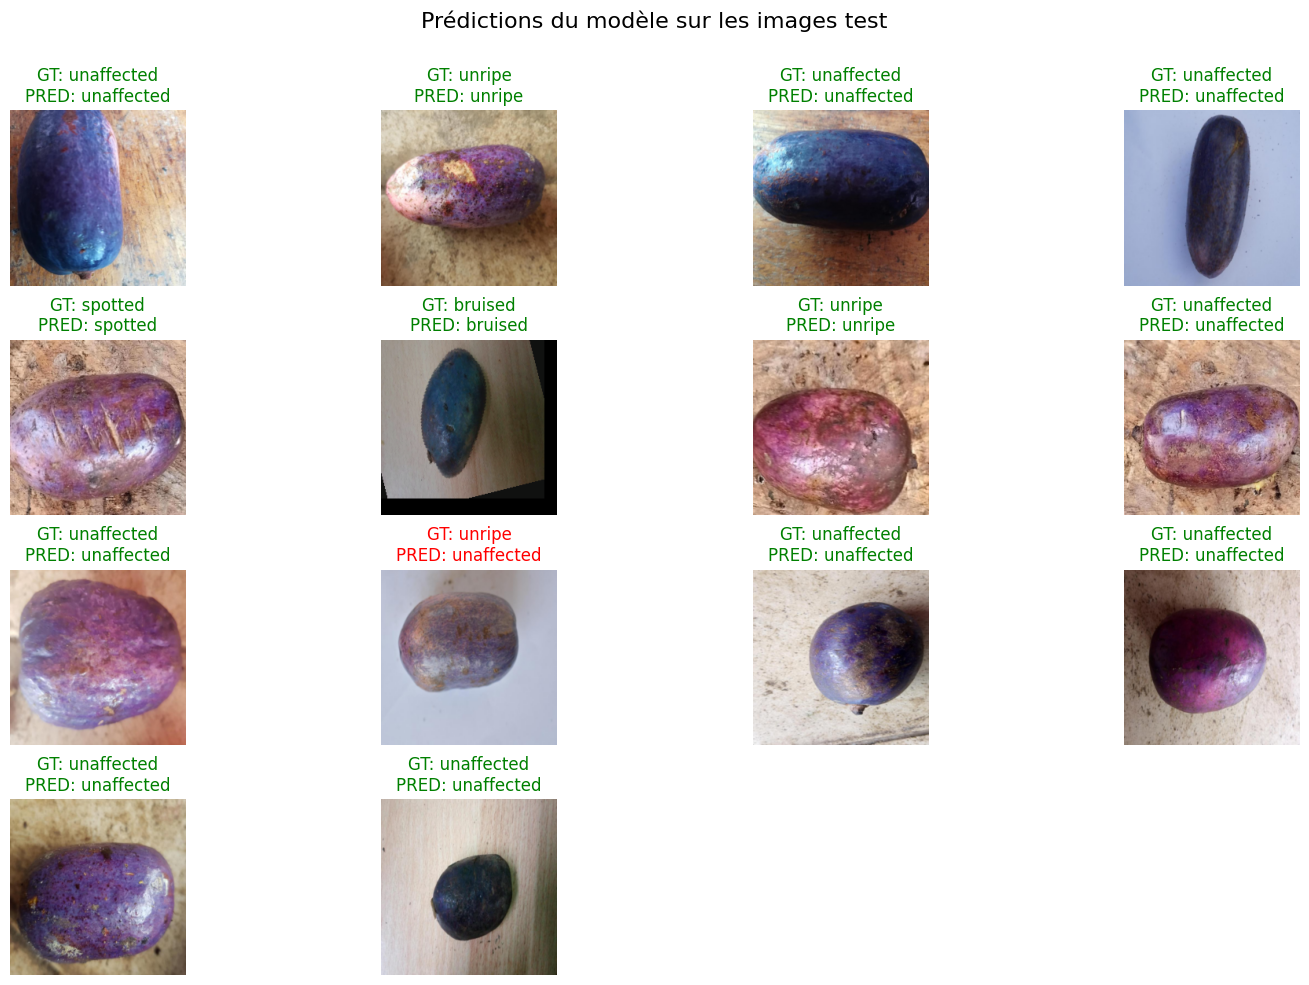

In [23]:
# Recréer le modèle avec la bonne architecture
model = build_model('resnext50_32x4d', num_classes=len(class_names))

# Affichage
show_predictions(
    model=model,
    model_path='/content/drive/MyDrive/models/resnext50_32x4d.pth',
    test_loader=test_loader,
    class_names=class_names,
    device=device,
    num_images=14
)


# Conclusion des évaluations et tests

Au terme de nos expérimentations sur la classification automatique des prunes africaines, nous avons testé plusieurs **modèles de CNN pré-entraînés tels que EfficientNetB0, InceptionV3 , et ResNeXt50_32x4d**. Les évaluations ont été menées à l’aide de métriques robustes (accuracy, F1-score, précision, recall) sur un jeu de test bien séparé. Globalement, les modèles ont obtenu de bonnes performances, mais `EfficientNetB0` s’est démarqué avec une précision globale de `90%`, suivi de près par `InceptionV3`. La visualisation des prédictions a confirmé que ces modèles identifient bien les prunes saines ou pourries, bien que quelques confusions persistent entre les classes visuellement proches comme bruised et cracked. Grâce à l’augmentation ciblée des données pour les classes sous-représentées, nous avons amélioré la généralisation. Ces résultats montrent que notre solution basée sur le deep learning est à la fois efficace, rapide et exploitable en production via une interface web.



# Références

Kaggle Dataset : African Plums Dataset – https://www.kaggle.com/datasets/killa92/african-plums-quality-and-defect-assessment-data

Paper: Grad-CAM – Selvaraju et al. (2017)
    
Paper: EfficientNet – Tan & Le (2019)

Hugging Face & TIMM Models Repository – https://github.com/

huggingface/pytorch-image-models

kaggle code : https://www.kaggle.com/code/killa92/african-plums-vis-classification-model-analysis

Gemini AI: structure du projet et correction des bugs


